In [1]:
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import gsw
from seabird.cnv import fCNV

from cast_to_xarray import *

# Cartopy for producing maps
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features

import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.ticker as mticker

# Get all casts as xarray using function

In [3]:
data_dir = 'data_cruise1'

cast4xr = cast_to_xarray(data_dir+'/Station4_TSwift_loop_filter_teos10_bin.cnv', 4)
cast5xr = cast_to_xarray(data_dir+'/Station5_loop_filter_teos10_bin.cnv', 5)
castWFxr = cast_to_xarray(data_dir+'/StationWF_loop_filter_teos10_bin.cnv', 1)
castRacexr = cast_to_xarray(data_dir+'/TheRace_loop_filter_teos10_bin.cnv', 2)

# Combine casts

In [4]:
# combine all the casts into one xarray dataset
ctdsection = xr.concat([cast4xr,cast5xr,castWFxr, castRacexr],"cast")
ctdsection

<xarray.Dataset>
Dimensions:       (cast: 4, depth: 159)
Coordinates:
  * depth         (depth) float64 1.5 2.0 2.5 3.0 3.5 ... 80.0 80.5 81.0 81.5
    latitude      (cast) float64 41.3 41.14 41.05 41.25
    longitude     (cast) float64 -71.84 -71.65 -71.47 -72.09
    station       (cast) int64 4 5 1 2
Dimensions without coordinates: cast
Data variables:
    temperature   (cast, depth) float64 nan nan 0.9262 nan ... 19.15 19.15 19.15
    salinity      (cast, depth) float64 nan nan 1.558 nan ... 31.71 31.71 31.71
    fluorescence  (cast, depth) float64 nan nan 0.0908 nan ... 1.152 1.097 1.164

In [5]:
# calculate distance
d = gsw.distance(ctdsection.longitude.values,ctdsection.latitude.values)/1e3 # km
dist = np.cumsum(np.hstack([0,d]))

# add distance coordinate
ctdsection = ctdsection.assign_coords({'distance' : xr.DataArray(dist, coords=[ctdsection.station], dims='cast')})

ctdsection.distance.attrs['units'] = 'km'
#ctdsection

In [6]:
# add units for others
ctdsection.depth.attrs['units'] = 'm'
ctdsection.temperature.attrs['units'] = 'degree C'
ctdsection.salinity.attrs['units'] = 'psu'
ctdsection.fluorescence.attrs['units'] = 'mg/m^3'

# Map to understand plot

RuntimeError: NetCDF: Access failure

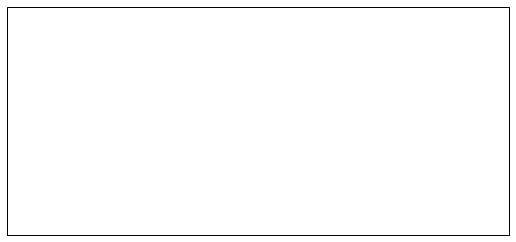

In [7]:
extent = [-74,-69.6,40,42]

# Download ETOPO1 topography for the domain(this may take a minute)
url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'
bat = xr.open_dataset(url)
bat = bat.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[2],extent[3]))

projection = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(9, 13),
                           subplot_kw=dict(projection=projection))
ax.set_extent(extent)

# Plot topography
bat['topo'].plot.contourf(
        ax=ax,levels=np.linspace(-500,100,10),add_colorbar=False,extend='neither',cmap='Blues_r',transform=projection)

_ = ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                edgecolor='face', facecolor='0.2'),
                                                zorder=3)

# plot ADCP track
plt.plot(ctdsection.longitude, ctdsection.latitude, color='yellow')

# plot CTD stations
ctdsection.plot.scatter('longitude', 'latitude', color='tab:red')#,transform=projection)

gl = ax.gridlines(draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')

plt.plot(-73.8, 41.75,'ro',transform=projection,zorder=5)
plt.text(-73.7,41.74,'CTD stations',color='w',transform=projection,zorder=5)

# Plotting sections

Text(0.5, 1.0, 'Temperature Section')

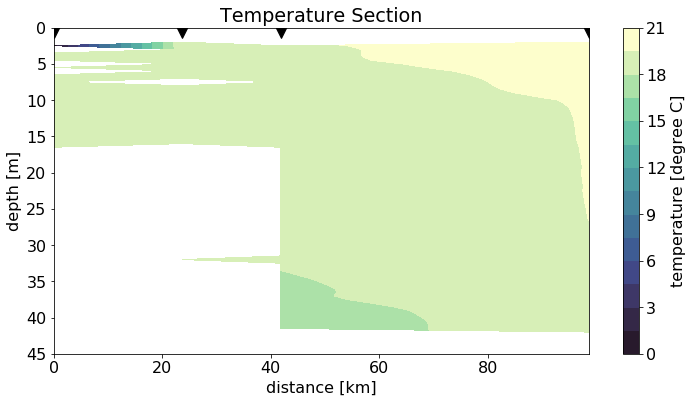

In [11]:
def beautifications(ax):
    ax.plot(ctdsection.distance,ctdsection.distance.size*[0],
             'kv',markersize=20)
    ax.set_ylim(45,0)
#    ax.set_xlim(-.5,10)
    
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
ctdsection.temperature.plot.contourf('distance','depth',levels=20,cmap=cmocean.cm.deep_r)
beautifications(ax)

plt.title("Temperature Section")

# plt.savefig('Figures/temperaturesection789.png')

Text(0.5, 1.0, 'Salinity Section')

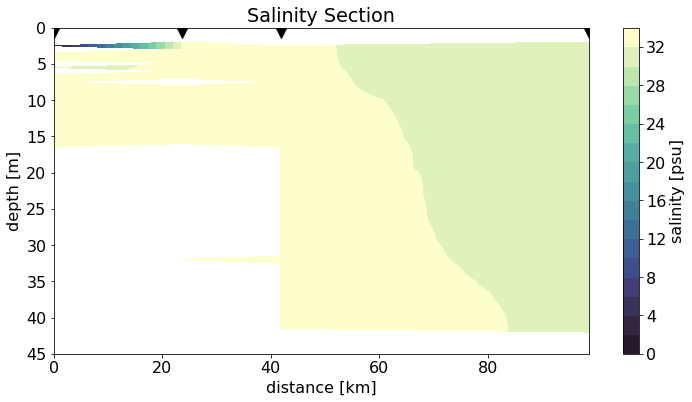

In [9]:
def beautifications(ax):
    ax.plot(ctdsection.distance,ctdsection.distance.size*[0],
             'kv',markersize=20)
    ax.set_ylim(45,0)
#    ax.set_xlim(-.5,45.25)
    
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
ctdsection.salinity.plot.contourf('distance','depth',levels=20,cmap=cmocean.cm.deep_r)
beautifications(ax)

plt.title("Salinity Section")

#plt.savefig('Figures/salinitysection789.png')

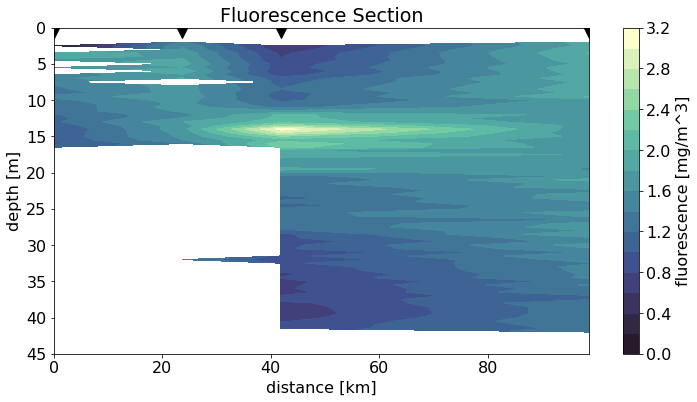

In [13]:
def beautifications(ax):
    ax.plot(ctdsection.distance,ctdsection.distance.size*[0],
             'kv',markersize=20)
    ax.set_ylim(45,0)
#    ax.set_xlim(-.5,45.25)
    
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 16})

ax = fig.add_subplot(111)
ctdsection.fluorescence.plot.contourf('distance','depth',levels=20,cmap=cmocean.cm.deep_r)
beautifications(ax)

plt.title("Fluorescence Section")

plt.savefig('Figures/Cruise1_fluorescence_allstations.png')